<a href="https://colab.research.google.com/github/divya20323/anomaly-power-usage/blob/main/anomaly_power_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!unzip household_power_consumption.zip


--2025-06-19 08:54:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘household_power_consumption.zip’

household_power_con     [   <=>              ]  19.68M  47.2MB/s    in 0.4s    

2025-06-19 08:54:28 (47.2 MB/s) - ‘household_power_consumption.zip’ saved [20640916]

Archive:  household_power_consumption.zip
  inflating: household_power_consumption.txt  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")


In [4]:
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'Datetime': ['Date', 'Time']},
                 infer_datetime_format=True, na_values=['?'],
                 low_memory=False)


/tmp/ipython-input-4-3908898280.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
/tmp/ipython-input-4-3908898280.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
/tmp/ipython-input-4-3908898280.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


In [5]:
# 📊 Keep only datetime index and power usage
df = df[['Datetime', 'Global_active_power']].dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)

# ⏳ Set datetime as index
df.set_index('Datetime', inplace=True)

# ⏱️ Resample to hourly average power usage
df_hourly = df.resample('H').mean().fillna(method='ffill')

# Preview the resampled data
df_hourly.head()


/tmp/ipython-input-5-1778309755.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean().fillna(method='ffill')
/tmp/ipython-input-5-1778309755.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly = df.resample('H').mean().fillna(method='ffill')


,Global_active_power
Datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


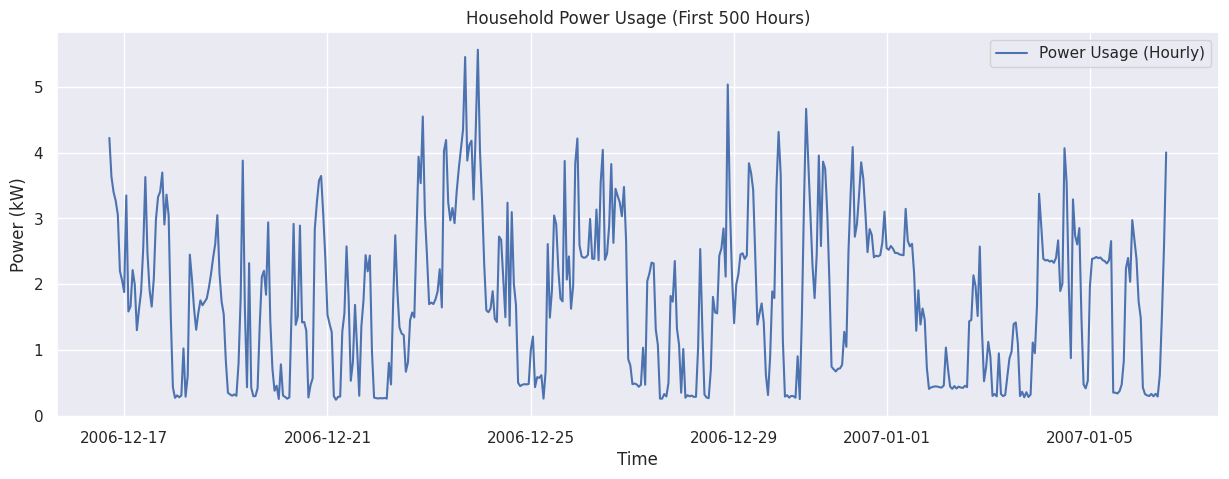

In [6]:
plt.figure(figsize=(15,5))
plt.plot(df_hourly.index[:500], df_hourly['Global_active_power'][:500], label='Power Usage (Hourly)')
plt.title("Household Power Usage (First 500 Hours)")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()


In [7]:
from sklearn.ensemble import IsolationForest

# 📦 Prepare input data
X = df_hourly[['Global_active_power']]

# ⚙️ Train Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
df_hourly['Anomaly_IF'] = model.fit_predict(X)

# 🔁 Convert output to binary (1 = anomaly, 0 = normal)
df_hourly['Anomaly_IF'] = df_hourly['Anomaly_IF'].map({1: 0, -1: 1})

# Show anomaly counts
df_hourly['Anomaly_IF'].value_counts()


,count
Anomaly_IF,
0,34243
1,346


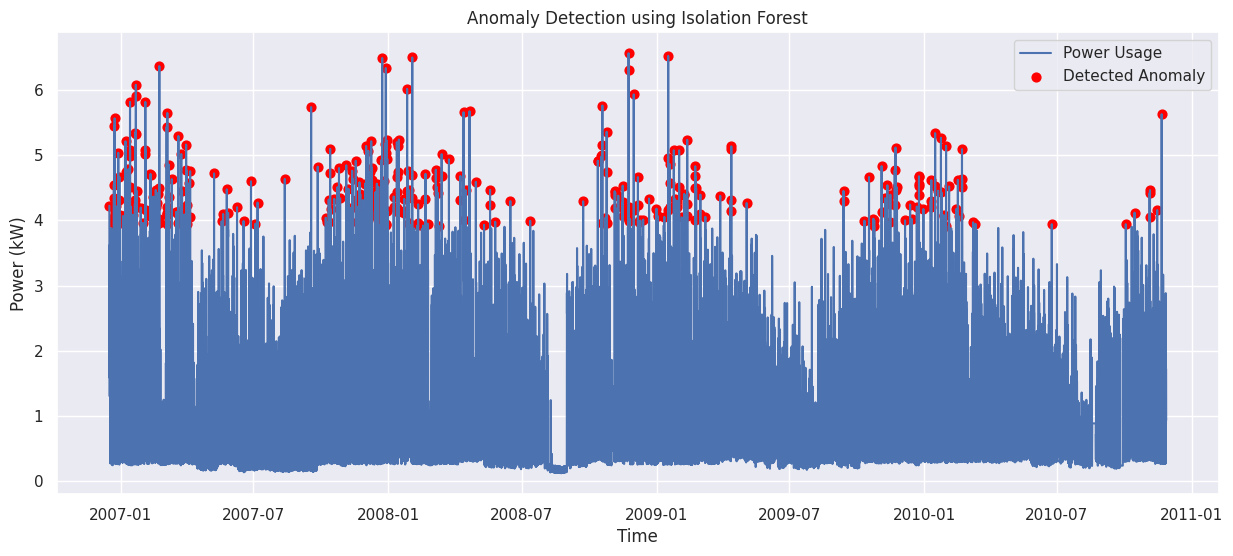

In [8]:
plt.figure(figsize=(15,6))
plt.plot(df_hourly.index, df_hourly['Global_active_power'], label='Power Usage')
plt.scatter(df_hourly[df_hourly['Anomaly_IF'] == 1].index,
            df_hourly[df_hourly['Anomaly_IF'] == 1]['Global_active_power'],
            color='red', label='Detected Anomaly', s=40)
plt.title("Anomaly Detection using Isolation Forest")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Scale the power usage to [0, 1]
scaler = MinMaxScaler()
df_hourly['Power_Scaled'] = scaler.fit_transform(df_hourly[['Global_active_power']])

# Split into train/test (use early data for training)
X = df_hourly[['Power_Scaled']].values
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape


((27671, 1), (6918, 1))

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define autoencoder model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=0)

print("✅ Training complete!")


✅ Training complete!


In [11]:
# Predict and calculate reconstruction error
X_pred = autoencoder.predict(X)
mse = np.mean(np.power(X - X_pred, 2), axis=1)

# Add to DataFrame
df_hourly['Reconstruction_Error'] = mse

# Define anomaly threshold (e.g., 95th percentile)
threshold = np.percentile(mse, 95)
df_hourly['Anomaly_AE'] = (mse > threshold).astype(int)

# Show some errors
df_hourly[['Global_active_power', 'Reconstruction_Error', 'Anomaly_AE']].head()


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,Global_active_power,Reconstruction_Error,Anomaly_AE
Datetime,,,
2006-12-16 17:00:00,4.222889,0.000628,1
2006-12-16 18:00:00,3.632200,0.000262,0
2006-12-16 19:00:00,3.400233,0.000116,0
2006-12-16 20:00:00,3.268567,0.000056,0
2006-12-16 21:00:00,3.056467,0.000006,0


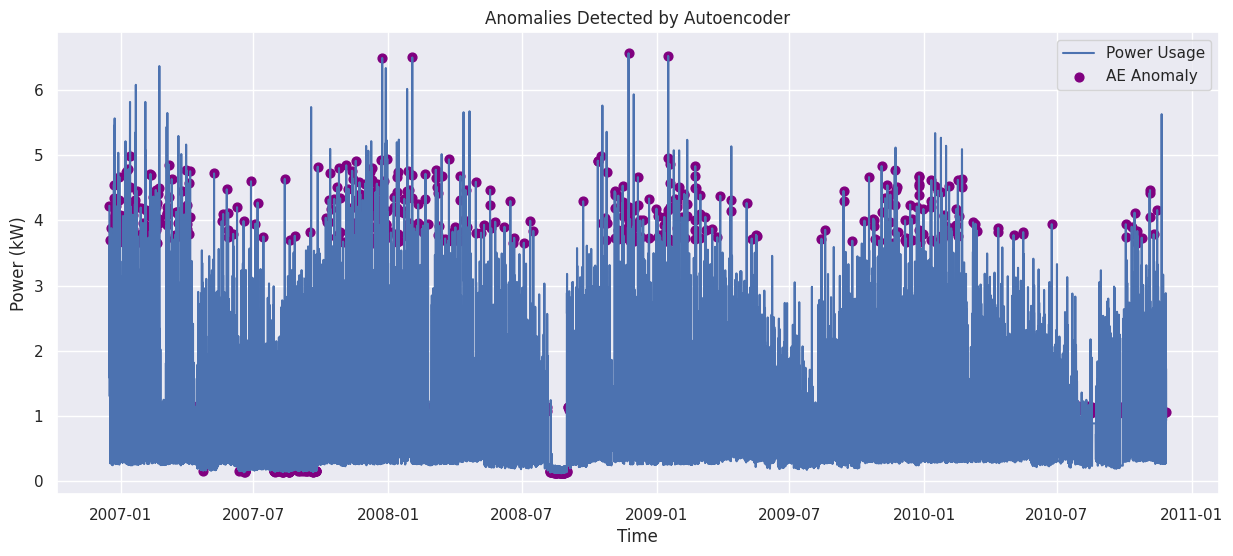

In [12]:
plt.figure(figsize=(15,6))
plt.plot(df_hourly.index, df_hourly['Global_active_power'], label='Power Usage')
plt.scatter(df_hourly[df_hourly['Anomaly_AE'] == 1].index,
            df_hourly[df_hourly['Anomaly_AE'] == 1]['Global_active_power'],
            color='purple', label='AE Anomaly', s=40)
plt.title("Anomalies Detected by Autoencoder")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()


In [13]:
print("🔎 Isolation Forest Anomalies:", df_hourly['Anomaly_IF'].sum())
print("🔎 Autoencoder Anomalies:", df_hourly['Anomaly_AE'].sum())

# How many time points were detected by both
both = (df_hourly['Anomaly_IF'] == 1) & (df_hourly['Anomaly_AE'] == 1)
print("✅ Detected by both models:", both.sum())


🔎 Isolation Forest Anomalies: 346
🔎 Autoencoder Anomalies: 1730
✅ Detected by both models: 293


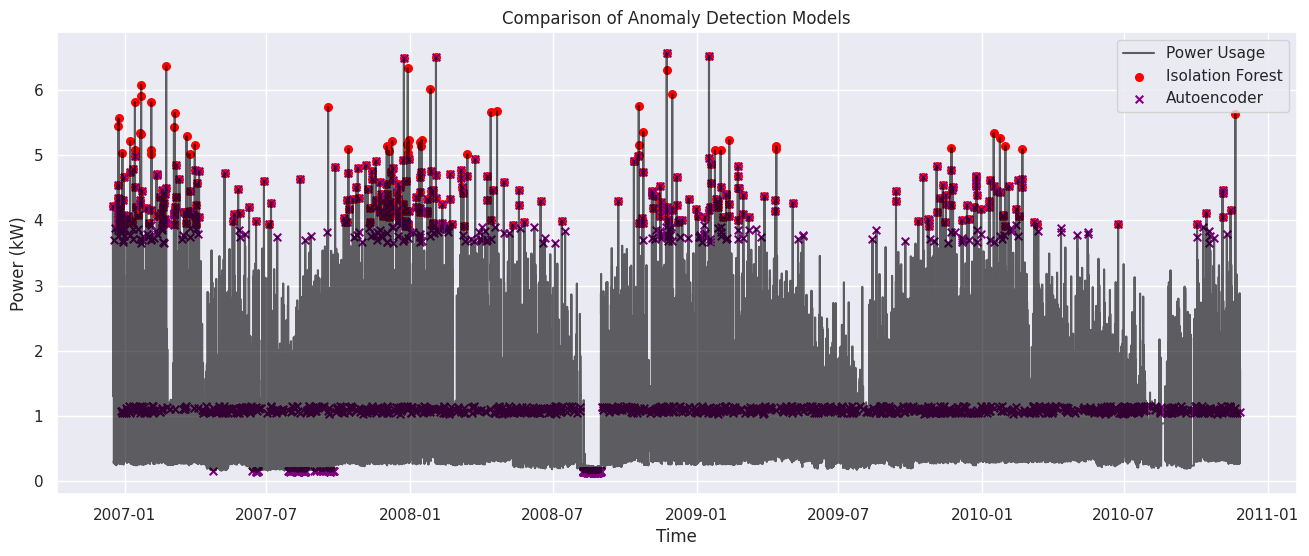

In [14]:
plt.figure(figsize=(16,6))
plt.plot(df_hourly.index, df_hourly['Global_active_power'], label='Power Usage', color='black', alpha=0.6)

# Isolation Forest anomalies
plt.scatter(df_hourly[df_hourly['Anomaly_IF'] == 1].index,
            df_hourly[df_hourly['Anomaly_IF'] == 1]['Global_active_power'],
            color='red', label='Isolation Forest', s=30)

# Autoencoder anomalies
plt.scatter(df_hourly[df_hourly['Anomaly_AE'] == 1].index,
            df_hourly[df_hourly['Anomaly_AE'] == 1]['Global_active_power'],
            color='purple', label='Autoencoder', s=30, marker='x')

plt.title("Comparison of Anomaly Detection Models")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()


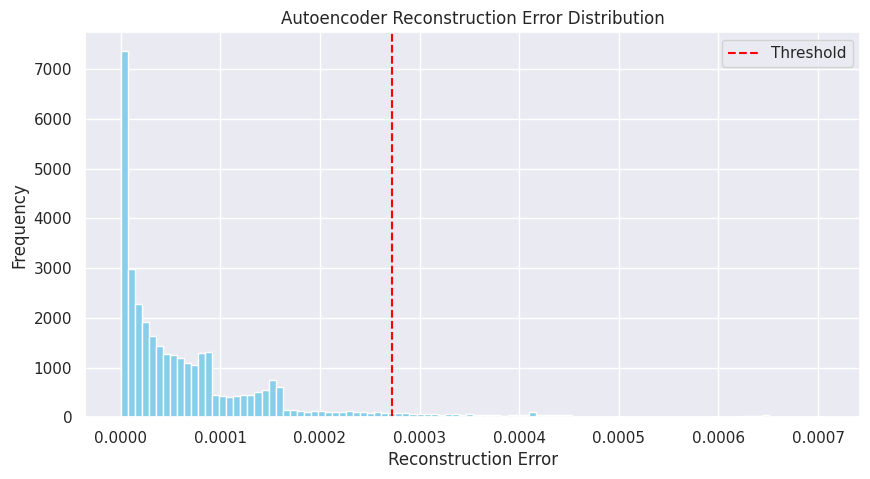

In [15]:
plt.figure(figsize=(10,5))
plt.hist(df_hourly['Reconstruction_Error'], bins=100, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [16]:
comparison_df = pd.DataFrame({
    'Total Points': [len(df_hourly)],
    'IF Anomalies': [df_hourly['Anomaly_IF'].sum()],
    'AE Anomalies': [df_hourly['Anomaly_AE'].sum()],
    'Both Models': [both.sum()]
})

print("📋 Model Comparison Summary:")
display(comparison_df)


📋 Model Comparison Summary:


,Total Points,IF Anomalies,AE Anomalies,Both Models
0,34589,346,1730,293
